In [1]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

import torch

import pandas as pd

from src.utils import plot_embeddings, plot_confusion_matrix, performance_metrics, ms_label2id, ms_id2label, load_ms_data

In [17]:
def show_results(file_name:str)->None:
    data = torch.load(paths.RESULTS_PATH/"ms-diag"/f"{file_name}.pt")
    last_hidden_state = [batch[-1,:] for batch in data["last_hidden_state"]]
    embeddings = torch.stack(last_hidden_state,dim = 0).to(torch.float16)
    labels = data["labels"]
    test_preds = data["test_preds"]
    plot_confusion_matrix(test_preds, labels, title=file_name, label2id=ms_label2id)
    print(performance_metrics(labels, test_preds), "\n\n")

# LLAMA2

## LoRa

{'accuracy': 0.9491525423728814, 'f1': 0.8474341192787795, 'precision': 0.8760683760683761, 'recall': 0.8267973856209151} 




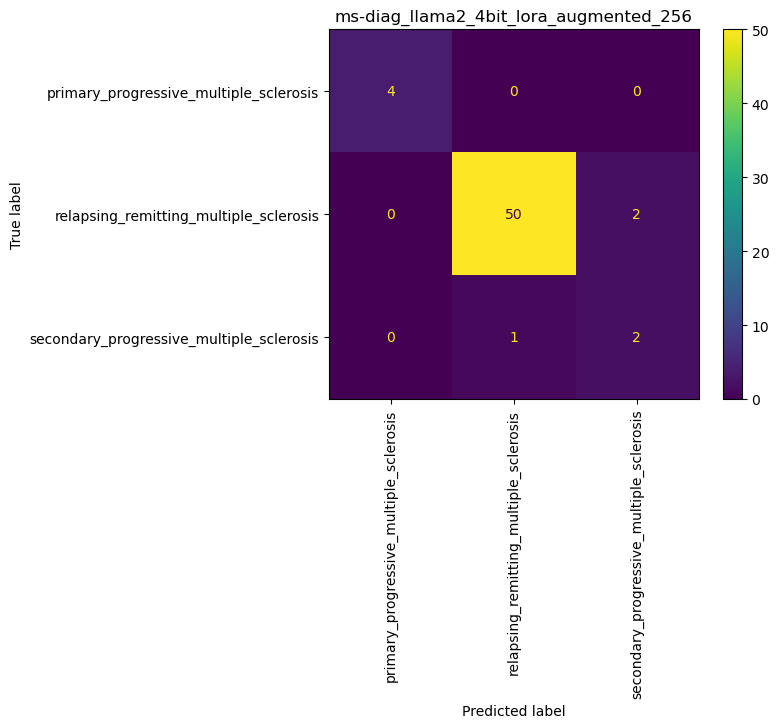

In [18]:
show_results("ms-diag_llama2_4bit_lora_augmented_256")

In [19]:
df = load_ms_data()

data = torch.load(paths.RESULTS_PATH/"ms-diag"/"ms-diag_llama2_4bit_lora_augmented_256.pt")
last_hidden_state = [batch[-1,:] for batch in data["last_hidden_state"]]
embeddings = torch.stack(last_hidden_state,dim = 0).to(torch.float16)
labels = data["labels"]
test_preds = data["test_preds"]

for i, label in enumerate(labels):
    if label != test_preds[i]:
        print("Entry: ", i)
        print("Label", ms_id2label[label])
        print("Predicted", ms_id2label[test_preds[i]])
        print("Text: ", df["test"][i]["text"])
        print("\n")

Entry:  3
Label relapsing_remitting_multiple_sclerosis
Predicted secondary_progressive_multiple_sclerosis
Text:  Schubförmige Multiple Sklerose mit V. a. sekundär chronisch progredienten Verlauf seit ca. 2016, EM 1997, ED 2003, EDSS 6.0 klinisch: nicht aktiv; radiologisch: nicht aktiv; Progression: nein (Lublin, 2013) aktuell: spastische ataktische Gangstörung beinbetont rechts, distal- und beinbetontes motorisches Hemisyndrom rechts, 6Min Gehtest 460m Verlauf:  INDENT 05/ 1997 1.Schub mit beidseitiger Visusminderung, vollständige Rückbildung INDENT 2003 - 2007 alle 1.5 - 2 Jahre ein Schub (motorische Störung der Beine), starke Depression  INDENT 2007 - 2014 mehrere Schübe unter Copaxone (Schubrate nicht bekannt)  INDENT 09/2014: Schub mit Gangunsicherheit und Parese des rechten Beines, Koordinationsstörungen der rechten Hand (inkomplette Regression der Parese des rechten Beines)  INDENT 11/2016 Progression der Steifigkeit und Ermüdbarkeit der rechten Bein in Vergleich zu vergangenen J

(59, 2)


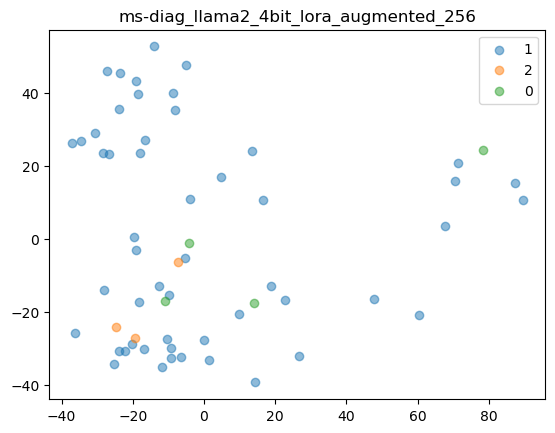

In [20]:
# Plot embeddings
plot_embeddings(embeddings, labels, title = "ms-diag_llama2_4bit_lora_augmented_256", method = "pca")

{'accuracy': 0.7966101694915254, 'f1': 0.29559748427672955, 'precision': 0.30128205128205127, 'recall': 0.29012345679012347} 




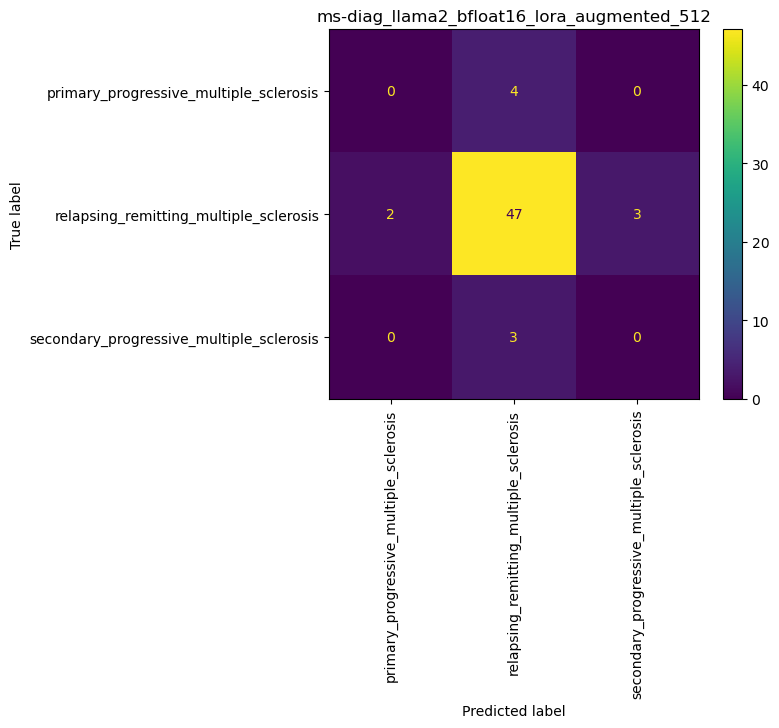

In [21]:
show_results("ms-diag_llama2_bfloat16_lora_augmented_512")

## Prompt Tuning

{'accuracy': 0.6101694915254238, 'f1': 0.3772714433669146, 'precision': 0.517094017094017, 'recall': 0.40223311546840956} 




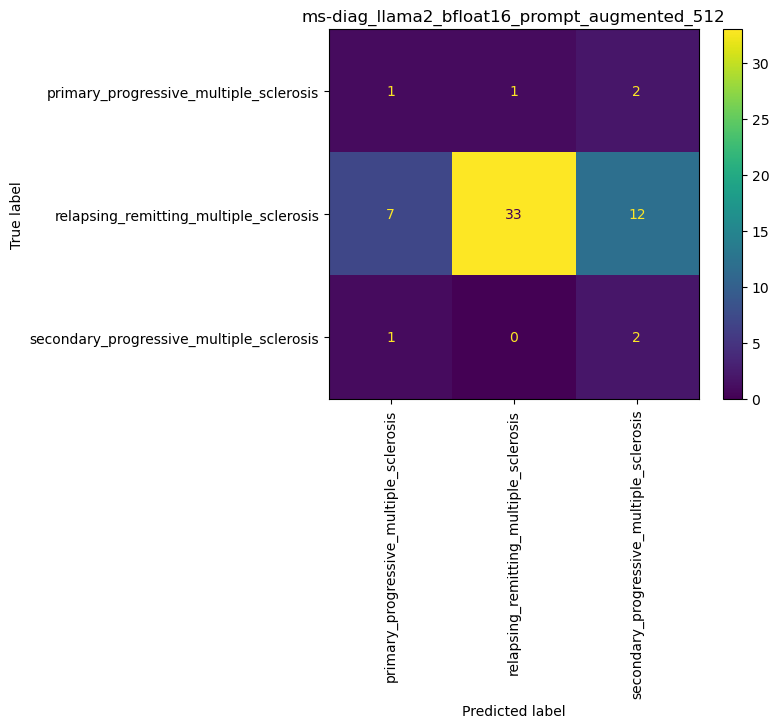

In [22]:
show_results("ms-diag_llama2_bfloat16_prompt_augmented_512")

## Ptune

{'accuracy': 0.3559322033898305, 'f1': 0.20860370103340542, 'precision': 0.2884615384615385, 'recall': 0.3211951447245565} 




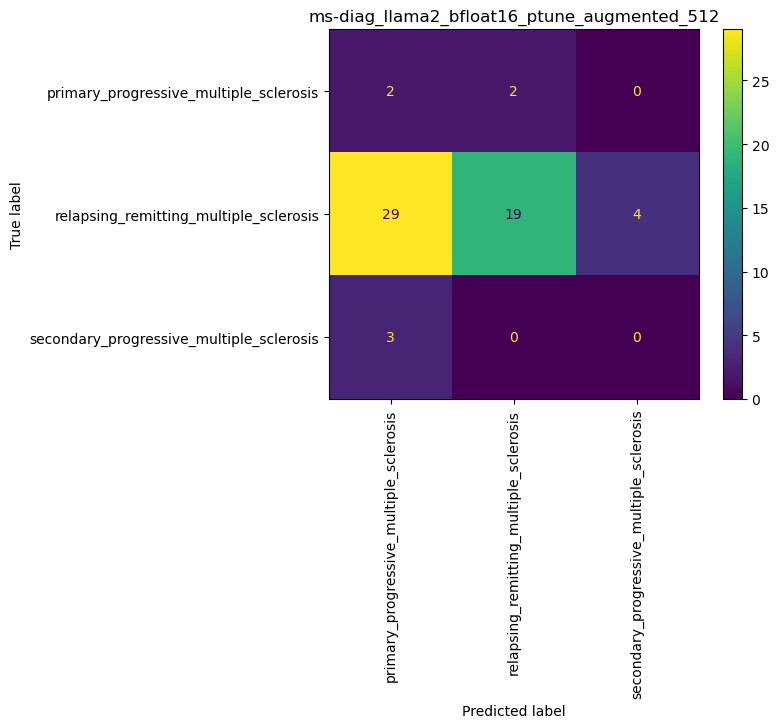

In [23]:
show_results("ms-diag_llama2_bfloat16_ptune_augmented_512")

# MedBERT finetuning

## Original

{'accuracy': 0.8983050847457628, 'f1': 0.41037735849056606, 'precision': 0.4444444444444444, 'recall': 0.38765432098765434} 




/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


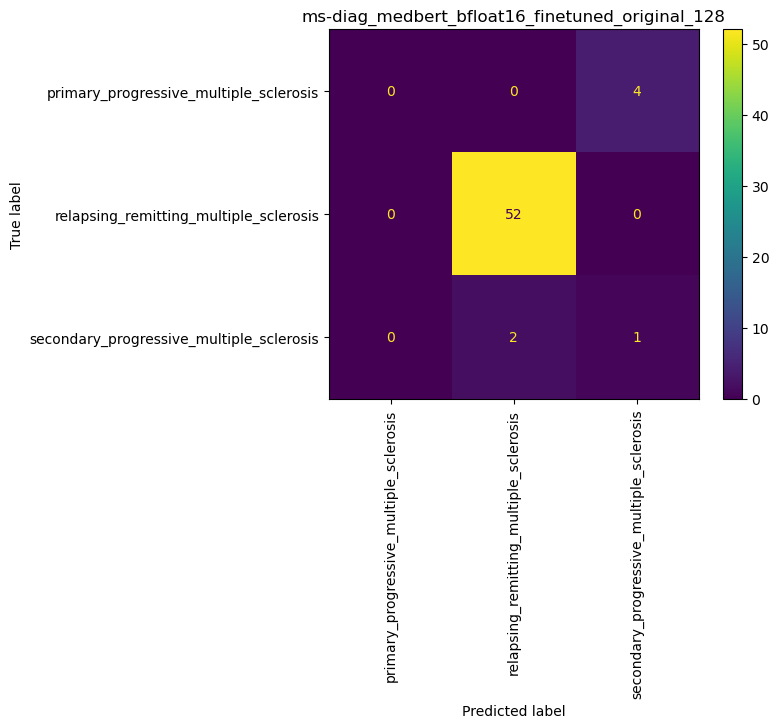

In [24]:
show_results("ms-diag_medbert_bfloat16_finetuned_original_128")

{'accuracy': 0.8813559322033898, 'f1': 0.3123123123123123, 'precision': 0.3333333333333333, 'recall': 0.2937853107344633} 




/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


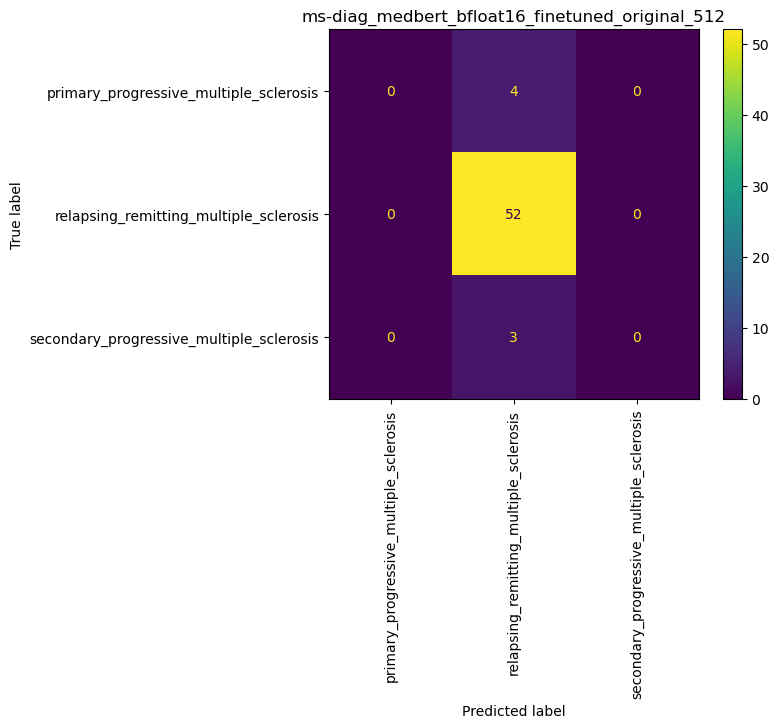

In [25]:
show_results("ms-diag_medbert_bfloat16_finetuned_original_512")

## Augmented

{'accuracy': 0.9830508474576272, 'f1': 0.9047619047619048, 'precision': 0.9166666666666666, 'recall': 0.9166666666666666} 




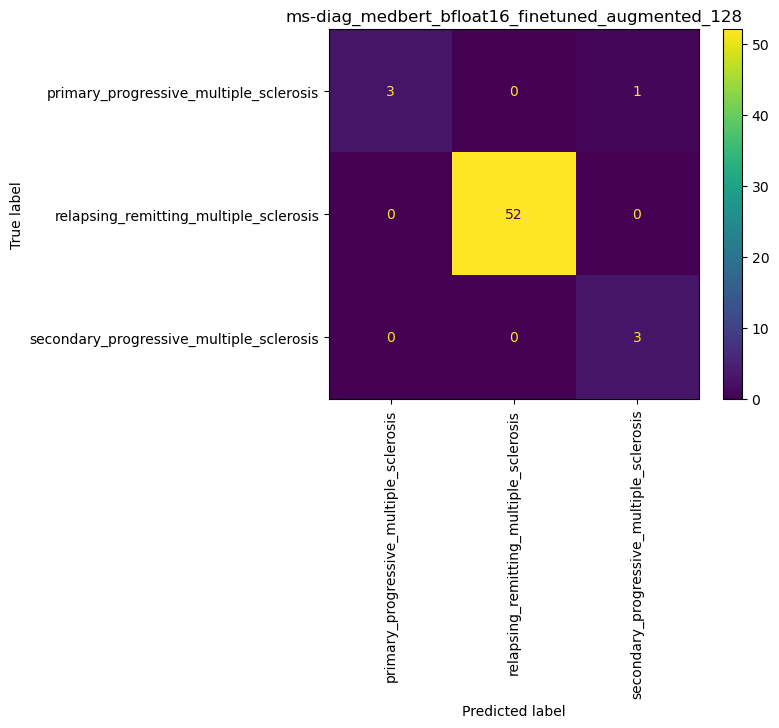

In [26]:
show_results("ms-diag_medbert_bfloat16_finetuned_augmented_128")

{'accuracy': 0.8813559322033898, 'f1': 0.3123123123123123, 'precision': 0.3333333333333333, 'recall': 0.2937853107344633} 




/cluster/customapps/biomed/grlab/users/eglimar/conda/envs/inf-extr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


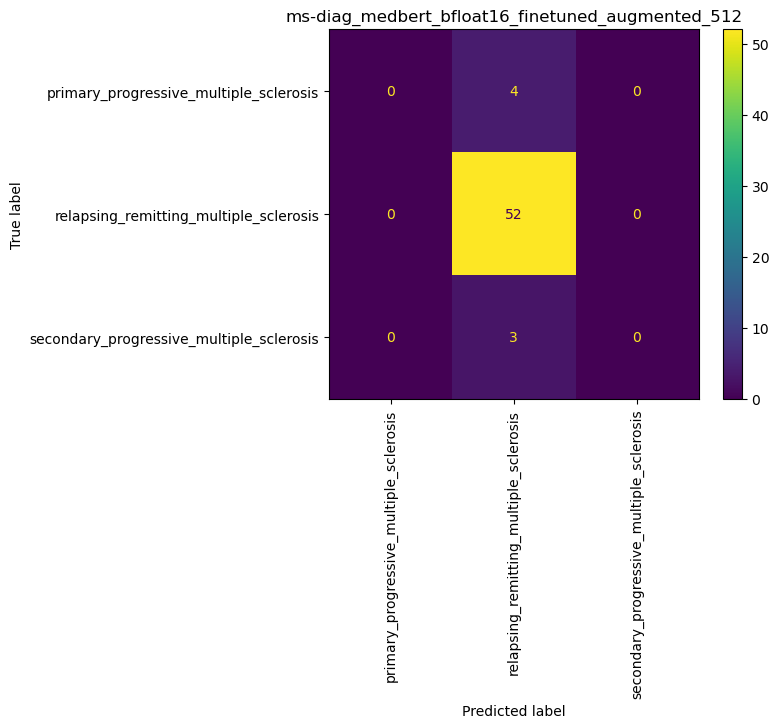

In [27]:
show_results("ms-diag_medbert_bfloat16_finetuned_augmented_512")

## Zero-Shot

{'accuracy': 0.9491525423728814, 'f1': 0.803113553113553, 'precision': 0.7991452991452991, 'recall': 0.826923076923077} 




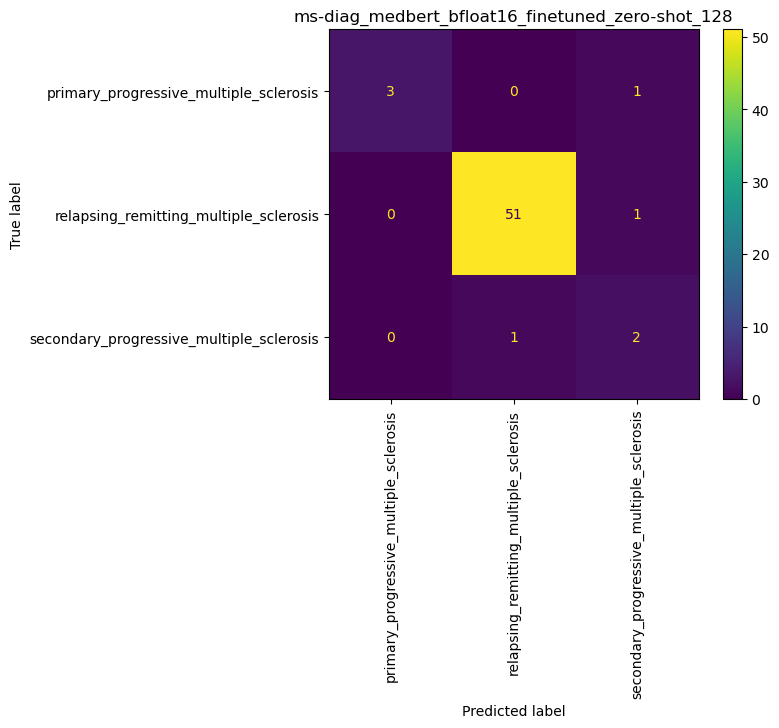

In [28]:
show_results("ms-diag_medbert_bfloat16_finetuned_zero-shot_128")

{'accuracy': 0.9322033898305084, 'f1': 0.7641007859454462, 'precision': 0.7927350427350427, 'recall': 0.7434640522875817} 




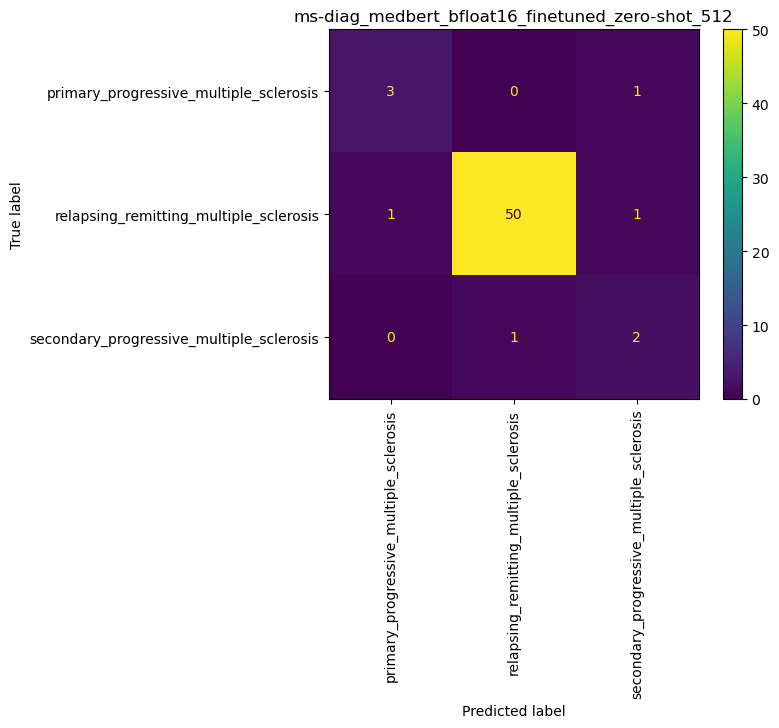

In [29]:
show_results("ms-diag_medbert_bfloat16_finetuned_zero-shot_512")